In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import cv2 as cv
import numpy as np
# from numba import cuda
from datetime import datetime

from utils import process_raw_data, draw_segmentation_mask
from utils import weighted_categorical_crossentropy

2023-01-22 10:41:05.032140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-22 10:41:05.732128: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/bojan/miniconda3/envs/unet/lib/
2023-01-22 10:41:05.732190: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/bojan/miniconda3/envs/unet/lib/
2023-01-22 10:41:05.732212: W tensorflow/compiler/tf

In [2]:
# Check if a GPU device is available
import tensorflow as tf
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-01-22 10:41:06.369993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 10:41:06.375274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 10:41:06.375933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
IMG_WIDTH = 640
IMG_HEIGHT = 480
IMG_CHANNELS = 3

num_classes = 3

In [4]:
# Contracting path
num_filters = 64
dropout_rate = 0.1
filter_size = (3, 3)

input = layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
c1 = layers.Conv2D(num_filters, filter_size, padding="same", activation="relu", kernel_initializer="he_normal")(input)
c1 = layers.Dropout(dropout_rate)(c1)
c1 = layers.Conv2D(num_filters, filter_size, padding="same", activation="relu", kernel_initializer="he_normal")(c1)
p1 = layers.MaxPool2D((2, 2), (2, 2))(c1)

c2 = layers.Conv2D(2*num_filters, filter_size, padding="same", activation="relu", kernel_initializer="he_normal")(p1)
c2 = layers.Dropout(dropout_rate)(c2)
c2 = layers.Conv2D(2*num_filters, filter_size, padding="same", activation="relu", kernel_initializer="he_normal")(c2)
p2 = layers.MaxPool2D((2, 2), (2, 2))(c2)

c3 = layers.Conv2D(4*num_filters, filter_size, padding="same", activation="relu", kernel_initializer="he_normal")(p2)
c3 = layers.Dropout(dropout_rate)(c3)
c3 = layers.Conv2D(4*num_filters, filter_size, padding="same", activation="relu", kernel_initializer="he_normal")(c3)
p3 = layers.MaxPool2D((2, 2), (2, 2))(c3)

c4 = layers.Conv2D(8*num_filters, filter_size, padding="same", activation="relu", kernel_initializer="he_normal")(p3)
c4 = layers.Dropout(dropout_rate)(c4)
c4 = layers.Conv2D(8*num_filters, filter_size, padding="same", activation="relu", kernel_initializer="he_normal")(c4)
p4 = layers.MaxPool2D((2, 2), (2, 2))(c4)

c5 = layers.Conv2D(16*num_filters, filter_size, padding="same", activation="relu", kernel_initializer="he_normal")(p4)
c5 = layers.Dropout(dropout_rate)(c5)
c5 = layers.Conv2D(16*num_filters, filter_size, padding="same", activation="relu", kernel_initializer="he_normal")(c5)

2023-01-22 10:41:06.405334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-22 10:41:06.405625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 10:41:06.406294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 10:41:06.406781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [5]:
# Expanding path
u6 = layers.Conv2DTranspose(8*num_filters, (2, 2), (2, 2), padding="same")(c5)
c6 = layers.Concatenate(axis=3)([c4, u6])
c6 = layers.Conv2D(8*num_filters, filter_size, padding="same", activation="relu", kernel_initializer="he_normal")(c6)
c6 = layers.Dropout(dropout_rate)(c6)
c6 = layers.Conv2D(8*num_filters, filter_size, padding="same", activation="relu", kernel_initializer="he_normal")(c6)

u7 = layers.Conv2DTranspose(4*num_filters, (2, 2), (2, 2), padding="same")(c6)
c7 = layers.Concatenate(axis=3)([c3, u7])
c7 = layers.Conv2D(4*num_filters, filter_size, padding="same", activation="relu", kernel_initializer="he_normal")(c7)
c7 = layers.Dropout(dropout_rate)(c7)
c7 = layers.Conv2D(4*num_filters, filter_size, padding="same", activation="relu", kernel_initializer="he_normal")(c7)

u8 = layers.Conv2DTranspose(2*num_filters, (2, 2), (2, 2), padding="same")(c7)
c8 = layers.Concatenate(axis=3)([c2, u8])
c8 = layers.Conv2D(2*num_filters, filter_size, padding="same", activation="relu", kernel_initializer="he_normal")(c8)
c8 = layers.Dropout(dropout_rate)(c8)
c8 = layers.Conv2D(2*num_filters, filter_size, padding="same", activation="relu", kernel_initializer="he_normal")(c8)

u9 = layers.Conv2DTranspose(num_filters, (2, 2), (2, 2), padding="same")(c8)
c9 = layers.Concatenate(axis=3)([c1, u9])
c9 = layers.Conv2D(num_filters, filter_size, padding="same", activation="relu", kernel_initializer="he_normal")(c9)
c9 = layers.Dropout(dropout_rate)(c9)
c9 = layers.Conv2D(num_filters, filter_size, padding="same", activation="relu", kernel_initializer="he_normal")(c9)

output = layers.Conv2D(num_classes, (1, 1), activation="softmax")(c9)

In [6]:
unet_model = keras.Model(inputs=[input], outputs=[output])

optimizer = keras.optimizers.Nadam(learning_rate=1e-5)

weights = [4, 1, 2]
loss = weighted_categorical_crossentropy(weights)

unet_model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 480, 640, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 480, 640, 64  0           ['conv2d[0][0]']                 
                                )                                                             

                                6)                                                                
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 240, 320, 12  131200     ['conv2d_13[0][0]']              
 spose)                         8)                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 240, 320, 25  0           ['conv2d_3[0][0]',               
                                6)                                'conv2d_transpose_2[0][0]']     
                                                                                                  
 conv2d_14 (Conv2D)             (None, 240, 320, 12  295040      ['concatenate_2[0][0]']          
                                8)                                                                
          

In [7]:
raw_data_path = "../data/raw_data/"
train_path = "../data/train/"
test_path = "../data/test/"

label_names = ["korov", "maticnjak"]
member_names = ["ivan", "mladen", "dino", "milan", "bojan"]
test_ratio = 0.1

# process_raw_data(raw_data_path, train_path, test_path, member_names, label_names, test_ratio)

In [8]:
data_gen_args = dict(rotation_range=5,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     zoom_range=0.05,
                     fill_mode="reflect",
                     horizontal_flip=True,
                     vertical_flip=True,
                     rescale=1./255,
                     validation_split=0.15)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1

train_image_generator = image_datagen.flow_from_directory(
    train_path + "input/",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    batch_size=1,
    seed=seed,
    subset="training"
)

train_label_generator = mask_datagen.flow_from_directory(
    train_path + "output/",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    batch_size=1,
    seed=seed,
    subset="training"
)

train_generator = zip(train_image_generator, train_label_generator)

seed = 100

valid_image_generator = image_datagen.flow_from_directory(
    train_path + "input/",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    batch_size=1,
    seed=seed,
    subset="validation"
)

valid_label_generator = mask_datagen.flow_from_directory(
    train_path + "output/",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    batch_size=1,
    seed=seed,
    subset="validation"
)

validation_generator = zip(train_image_generator, train_label_generator)

Found 259 images belonging to 1 classes.
Found 259 images belonging to 1 classes.
Found 45 images belonging to 1 classes.
Found 45 images belonging to 1 classes.


In [9]:
now = datetime.now()
log_dir = "tf_logs/" + now.strftime("%Y%m%d-%H%M%S") + "/"

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
    keras.callbacks.ModelCheckpoint(filepath="../saved_models/unet_model.h5", save_best_only=True),
    keras.callbacks.TensorBoard(log_dir=log_dir)
]

In [10]:
unet_model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=1000,
    validation_data=validation_generator,
    validation_steps=100,
    callbacks=callbacks
)

Epoch 1/10


2023-01-22 10:41:10.830446: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-01-22 10:41:11.624897: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-01-22 10:41:11.892267: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-22 10:41:15.269434: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f81f812a0b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-22 10:41:15.269460: I tensorflow/compiler/xla/servi

2023-01-22 10:41:18.352468: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-22 10:41:18.512880: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-22 10:41:18.668838: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

2023-01-22 10:41:22.102380: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-22 10:41:22.255281: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-22 10:41:22.408324: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

1000/1000 [==============================] - 207s 192ms/step - loss: 1.1729 - accuracy: 0.7939 - val_loss: 1.1950 - val_accuracy: 0.7564
Epoch 2/10
1000/1000 [==============================] - 193s 193ms/step - loss: 0.9086 - accuracy: 0.8485 - val_loss: 1.1689 - val_accuracy: 0.7756
Epoch 3/10
1000/1000 [==============================] - 192s 192ms/step - loss: 0.8144 - accuracy: 0.8633 - val_loss: 0.9287 - val_accuracy: 0.8412
Epoch 4/10
1000/1000 [==============================] - 192s 192ms/step - loss: 0.7784 - accuracy: 0.8703 - val_loss: 0.9241 - val_accuracy: 0.8519
Epoch 5/10
1000/1000 [==============================] - 191s 191ms/step - loss: 0.7388 - accuracy: 0.8778 - val_loss: 0.9645 - val_accuracy: 0.8407
Epoch 6/10
1000/1000 [==============================] - 192s 192ms/step - loss: 0.7160 - accuracy: 0.8817 - val_loss: 0.8614 - val_accuracy: 0.8754
Epoch 7/10
1000/1000 [==============================] - 192s 192ms/step - loss: 0.6957 - accuracy: 0.8841 - val_loss: 0.833

In [11]:
test_image_datagen = ImageDataGenerator(rescale=1./255)
test_mask_datagen = ImageDataGenerator(rescale=1./255)

seed = 1000

test_image_generator = test_image_datagen.flow_from_directory(
    test_path + "input/",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    batch_size=1,
    seed=seed
)

test_mask_generator = test_mask_datagen.flow_from_directory(
    test_path + "output/",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    batch_size=1,
    seed=seed
)

test_generator = zip(test_image_generator, test_mask_generator)

Found 24 images belonging to 1 classes.
Found 24 images belonging to 1 classes.


In [12]:
unet_model.evaluate(test_generator, steps=20)

20/20 [==============================] - 1s 42ms/step - loss: 0.7147 - accuracy: 0.8920


[0.7146849632263184, 0.8920092582702637]

In [13]:
img, mask_true = next(test_generator)

In [14]:
pred = unet_model.predict(img)
mask = tf.one_hot(tf.argmax(pred, axis=3), depth=num_classes)

img_pred = draw_segmentation_mask(np.uint8(img[0]*255), mask[0], 0.3)

cv.imshow("img", cv.cvtColor(img_pred, cv.COLOR_RGB2BGR))
cv.waitKey()
cv.destroyAllWindows()

img_true = draw_segmentation_mask(np.uint8(img[0]*255), np.round(mask_true[0]), 0.3)
cv.imshow("img", cv.cvtColor(img_true, cv.COLOR_RGB2BGR))
cv.waitKey()
cv.destroyAllWindows()

1/1 [==============================] - 0s 203ms/step


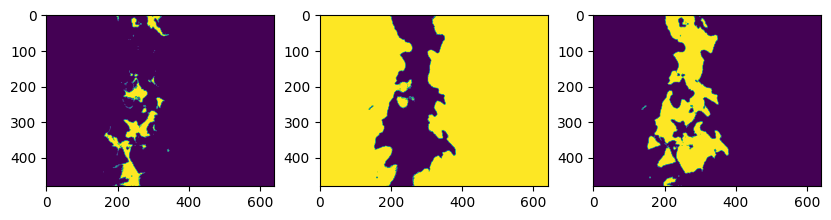

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(10, 10))

axes[0].imshow(mask[0, :, :, 0]*255)
axes[1].imshow(mask[0, :, :, 1]*255)
axes[2].imshow(mask[0, :, :, 2]*255)

In [16]:
# cuda.select_device(0)
# cuda.close()

In [17]:
unet_model.save("../saved_models/model.h5")